# FloPy
## MODFLOW-USG CLN package demo
This example problem demonstrates use of the CLN process for simulating flow to a well pumping from two aquifers seperated by an impermeable confining unit. A structured finite-difference grid with 100 rows and 100 columns was used. Each square cells is 470m by 470 m in extent. Initial heads are 10m in aquifer 1 and 30m in aquifer 2.

In [1]:
import os, shutil
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib.pyplot as plt

import flopy

In [2]:
# temporary directory
temp_dir = TemporaryDirectory()
cln_ws = temp_dir.name

## Loading Example 03_conduit_confined
The elevation of the top of layer 1 is -100 m, the bottom of layer 1 is -110 m, the top of layer 2 is -120 m and the bottom of layer 2 is -130 m. The confining unit between layers1 and 2 is impermeable and is represented using a quasi-three-dimensional approach. The only way a stress from one aquifer can be propagated to another is through the cln well that penetrates both aquifers.

The hydraulic conductivity values of the upper and lower aquifers are 100 and 400 m/d, respectively. Both aquifers have a primaey storage coefficient of 0.0001 and a specific yield of 0.01.

A vertical conduit well is located at the center of the domain and has a radius of 0.5 m. The well pumps 62,840 m3/d and is open fully to both aquifers from top to bottom. The CLN Process was used with a circular conduit geometry type to discretize the well bore with two conduit cells, one in each layer. The WEL Package was used to pump from the bottom CLN cell.


In [3]:
model_ws = os.path.join("../data/mfusg_test", "03_conduit_confined")
mf = flopy.mfusg.MfUsg.load(
    "ex3.nam", model_ws=model_ws, exe_name="mfusg", check=False, verbose=True
)


Creating new model with name: ex3
--------------------------------------------------

Parsing the namefile --> ../data/mfusg_test\03_conduit_confined\ex3.nam
could not set filehandle to ex3.lst
could not set filehandle to ex3.cbb
could not set filehandle to ex3.hds
could not set filehandle to ex3.ddn
could not set filehandle to ex3.clncbb
could not set filehandle to ex3.clnhds

--------------------------------------------------
External unit dictionary:
{7: filename:..\data\mfusg_test\03_conduit_confined\ex3.lst, filetype:LIST, 1: filename:..\data\mfusg_test\03_conduit_confined\ex3.bas, filetype:BAS6, 14: filename:..\data\mfusg_test\03_conduit_confined\ex3.wel, filetype:WEL, 12: filename:..\data\mfusg_test\03_conduit_confined\ex3.dis, filetype:DIS, 11: filename:..\data\mfusg_test\03_conduit_confined\ex3.bcf, filetype:BCF6, 13: filename:..\data\mfusg_test\03_conduit_confined\ex3.cln, filetype:CLN, 22: filename:..\data\mfusg_test\03_conduit_confined\ex3.oc, filetype:OC, 19: filename:..\

In [4]:
# output control
mf.remove_package("OC")

spd = {}
for i in range(mf.nper):
    for j in range(mf.dis.nstp[i]):
        spd[(i, j)] = ["save head", "save budget"]

oc = flopy.modflow.ModflowOc(
    mf, stress_period_data=spd, unitnumber=[22, 30, 31, 50]
)

removing Package:  ['OC']
adding Package:  OC


In [5]:
model_ws = os.path.join(cln_ws, "ex03")

if os.path.exists(model_ws):
    shutil.rmtree(model_ws)
os.mkdir(model_ws)

mf.model_ws = model_ws


changing model workspace...
   ..\..\..\..\AppData\Local\Temp\7\tmpwqz_bf4k\ex03


In [6]:
mf.write_input()
mf.run_model()


Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  WEL
   Package:  BCF6
   Package:  CLN
   Package:  SMS
   Package:  OC
 
FloPy is using the following executable to run the model: ..\..\..\..\flopy\bin\mfusg.EXE

                                  MODFLOW-USG      
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER FLOW MODEL
                             Version 1.5.00 02/27/2019                       

 Using NAME file: ex3.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/02/07 13:16:00

 Solving:  Stress period:     1    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Groundwater Flow Eqn.
 So

(True, [])

In [7]:
head_file = os.path.join(mf.model_ws, "ex3.clnhds")
headobj = flopy.utils.HeadFile(head_file)

In [8]:
simtimes = headobj.get_times()

nper = len(simtimes)

nnode = mf.cln.nclnnds

simhead = np.zeros((1, 1, nnode, nper))
for i in range(nper):
    simhead[:, :, :, i] = headobj.get_data(kstpkper=(i, 0))
simhead = np.squeeze(simhead)

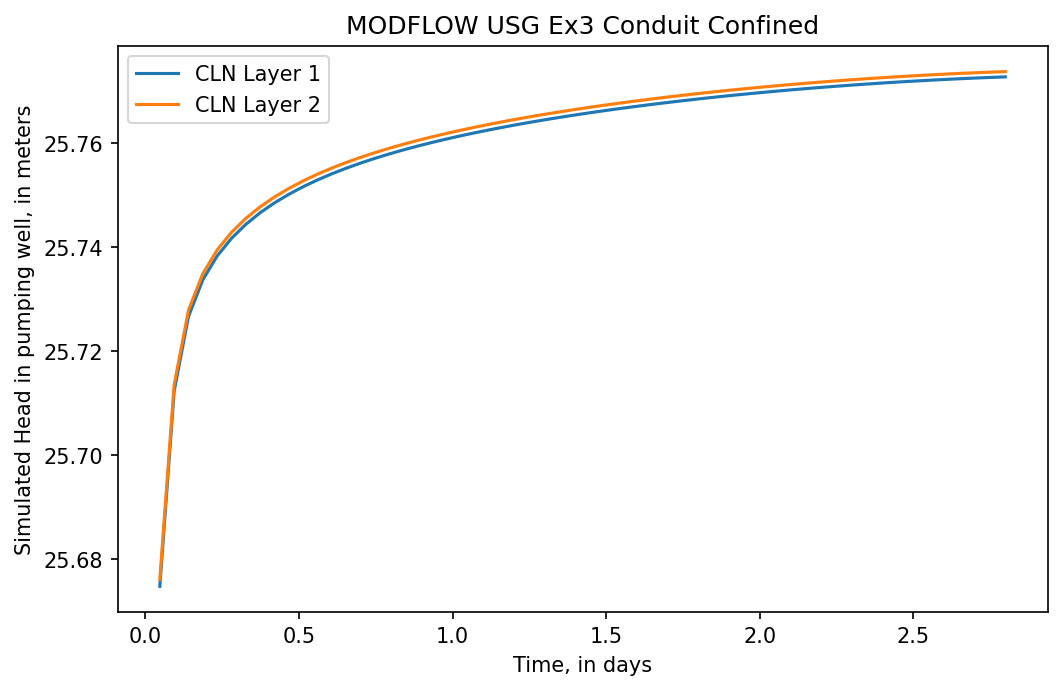

In [9]:
fig = plt.figure(figsize=(8, 5), dpi=150)
ax = fig.add_subplot(111)
ax.plot(simtimes, simhead[0], label="CLN Layer 1")
ax.plot(simtimes, simhead[1], label="CLN Layer 2")
ax.set_xlabel("Time, in days")
ax.set_ylabel("Simulated Head in pumping well, in meters")
ax.set_title("MODFLOW USG Ex3 Conduit Confined")
ax.legend()

In [10]:
cbb_file = os.path.join(mf.model_ws, "ex3.clncbb")
cbb = flopy.utils.CellBudgetFile(cbb_file)
# cbb.list_records()

simflow = cbb.get_data(kstpkper=(0, 0), text="GWF")[0]
for i in range(nper - 1):
    simflow = np.append(
        simflow, cbb.get_data(kstpkper=(i + 1, 0), text="GWF")[0]
    )
simflow1 = simflow[simflow["node"] == 1]["q"]
simflow2 = simflow[simflow["node"] == 2]["q"]

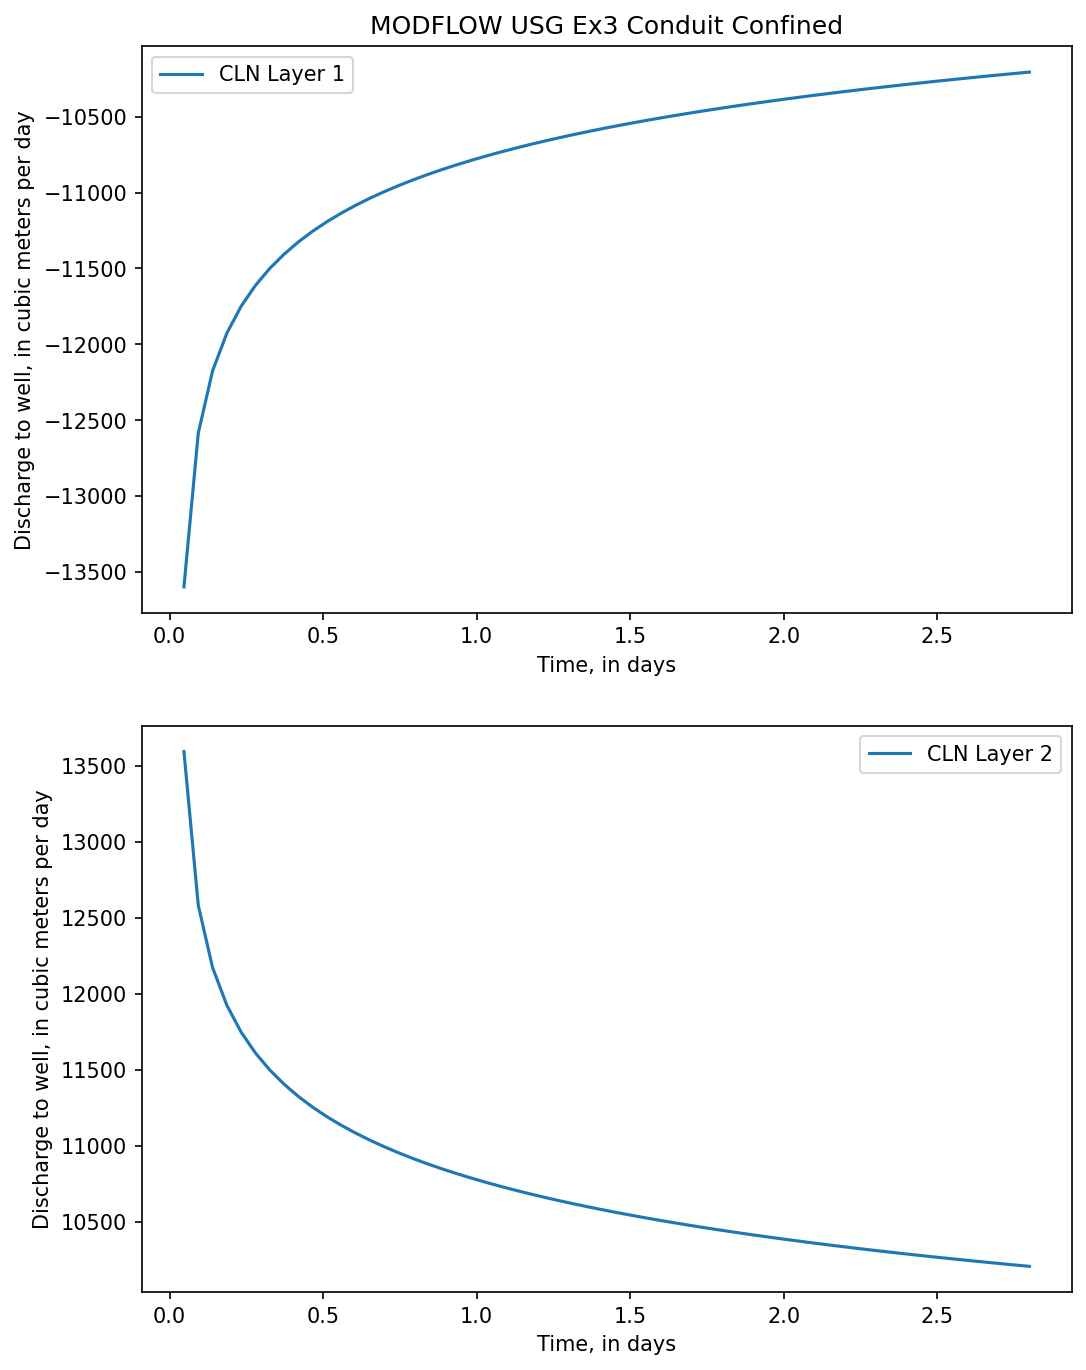

In [11]:
fig = plt.figure(figsize=(8, 11), dpi=150)
ax1 = fig.add_subplot(211)
ax1.plot(simtimes, simflow1, label="CLN Layer 1")
ax1.set_xlabel("Time, in days")
ax1.set_ylabel("Discharge to well, in cubic meters per day")
ax1.set_title("MODFLOW USG Ex3 Conduit Confined")
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(simtimes, simflow2, label="CLN Layer 2")
ax2.set_xlabel("Time, in days")
ax2.set_ylabel("Discharge to well, in cubic meters per day")
ax2.legend()

## Create example 03A_conduit_unconfined of mfusg 1.5
An unconfined example was simulated with this problem setup. The same simulation setup of previous example is used. However, the elevation of the top of layer 1 is 10 m, the bottom of layer 1 is 0 m, the top of layer 2 is -10 m, and the bottom of layer 2 is -20 m. The CLN domain is discretized using two vertical conduit cells. It depicts the behavior of unconfined flow in the conduit when the CLN cell in layer 1 becomes dry.

In [12]:
modelname = "ex03a"
model_ws = os.path.join(cln_ws, modelname)
mf = flopy.mfusg.MfUsg(
    modelname=modelname, model_ws=model_ws, exe_name="mfusg", verbose=True
)

In [13]:
ipakcb = 50

nlay = 2
nrow = 100
ncol = 100
laycbd = [1, 0]

delr = 470.000
delc = 470.000

ztop = 10.0
botm = [0.0, -10.0, -20.0]

perlen = 160
nstp = 160

dis = flopy.modflow.ModflowDis(
    mf,
    nlay,
    nrow,
    ncol,
    delr=delr,
    delc=delc,
    laycbd=laycbd,
    top=ztop,
    botm=botm,
    perlen=perlen,
    nstp=nstp,
    steady=False,
    lenuni=0,
)

bas = flopy.modflow.ModflowBas(mf, ibound=1, strt=[10.0, 30.0])

bcf = flopy.mfusg.MfUsgBcf(
    mf,
    ipakcb=ipakcb,
    laycon=4,
    wetfct=1.0,
    iwetit=5,
    hy=[100.0, 400.0],
    vcont=0.0,
    sf1=1e-4,
    sf2=0.01,
)

sms = flopy.mfusg.MfUsgSms(
    mf,
    hclose=1.0e-3,
    hiclose=1.0e-5,
    mxiter=220,
    iter1=600,
    iprsms=1,
    nonlinmeth=2,
    linmeth=1,
    theta=0.9,
    akappa=0.07,
    gamma=0.1,
    amomentum=0.0,
    numtrack=200,
    btol=1.1,
    breduc=0.2,
    reslim=1.0,
    iacl=2,
    norder=1,
    level=3,
    north=14,
)

adding Package:  DIS
adding Package:  BAS6
Adding ex03a.cbc (unit=50) to the output list.
adding Package:  BCF6
adding Package:  SMS


In [14]:
# output control
spd = {}
for i in range(mf.nper):
    for j in range(mf.dis.nstp[i]):
        spd[(i, j)] = ["save head", "save budget"]

oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd)

Adding ex03a.hds (unit=51) to the output list.
adding Package:  OC


In [15]:
unitnumber = [71, 35, 36, 0, 0, 0, 0]

node_prop = [
    [1, 1, 0, 10.0, 0.0, 1.57, 0, 0],
    [2, 1, 0, 10.0, -20.0, 1.57, 0, 0],
]
cln_gwc = [
    [1, 1, 50, 50, 0, 0, 10.0, 1.0, 0],
    [2, 2, 50, 50, 0, 0, 10.0, 1.0, 0],
]

nconduityp = 1
cln_circ = [[1, 0.5, 3.23e10]]

strt = [10.0, 30.0]
cln = flopy.mfusg.MfUsgCln(
    mf,
    ncln=1,
    iclnnds=-1,
    nndcln=2,
    nclngwc=2,
    node_prop=node_prop,
    cln_gwc=cln_gwc,
    cln_circ=cln_circ,
    strt=strt,
    unitnumber=unitnumber,
)

Adding ex03a.clncb (unit=35) to the output list.
Adding ex03a.clnhd (unit=36) to the output list.
adding Package:  CLN


In [16]:
options = []
options.append("autoflowreduce")
cln_stress_period_data = {0: [[1, -62840.0]]}

wel = flopy.mfusg.MfUsgWel(
    mf,
    ipakcb=ipakcb,
    options=options,
    cln_stress_period_data=cln_stress_period_data,
)

adding Package:  WEL


In [17]:
wel.cln_stress_period_data.data

{0: rec.array([(1, -62840.)],
           dtype=[('node', '<i4'), ('flux', '<f4')])}

In [18]:
mf.write_input()
mf.run_model()


Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  BCF6
   Package:  SMS
   Package:  OC
   Package:  CLN
   Package:  WEL
 
FloPy is using the following executable to run the model: ..\..\..\..\flopy\bin\mfusg.EXE

                                  MODFLOW-USG      
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER FLOW MODEL
                             Version 1.5.00 02/27/2019                       

 Using NAME file: ex03a.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/02/07 13:16:02

 Solving:  Stress period:     1    Time step:     1    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Groundwater Flow Eqn.
 

 Solving:  Stress period:     1    Time step:   103    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:   104    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:   105    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:   106    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:   107    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:   108    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:   109    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:   110    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:   111    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:   112    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:   113    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:   114    Groundwater Flow Eqn.
 Solving:  Stress period:     1    Time step:   115    Groundwater Flow Eqn.

(True, [])

In [19]:
head_file = os.path.join(mf.model_ws, modelname + ".clnhd")
headobj = flopy.utils.HeadFile(head_file)

simtimes = headobj.get_times()
nper = len(simtimes)
nnode = mf.cln.nclnnds

simhead = np.zeros((1, 1, nnode, nper))
for i in range(nper):
    simhead[:, :, :, i] = headobj.get_data(kstpkper=(i, 0))

head_case1 = np.squeeze(simhead)

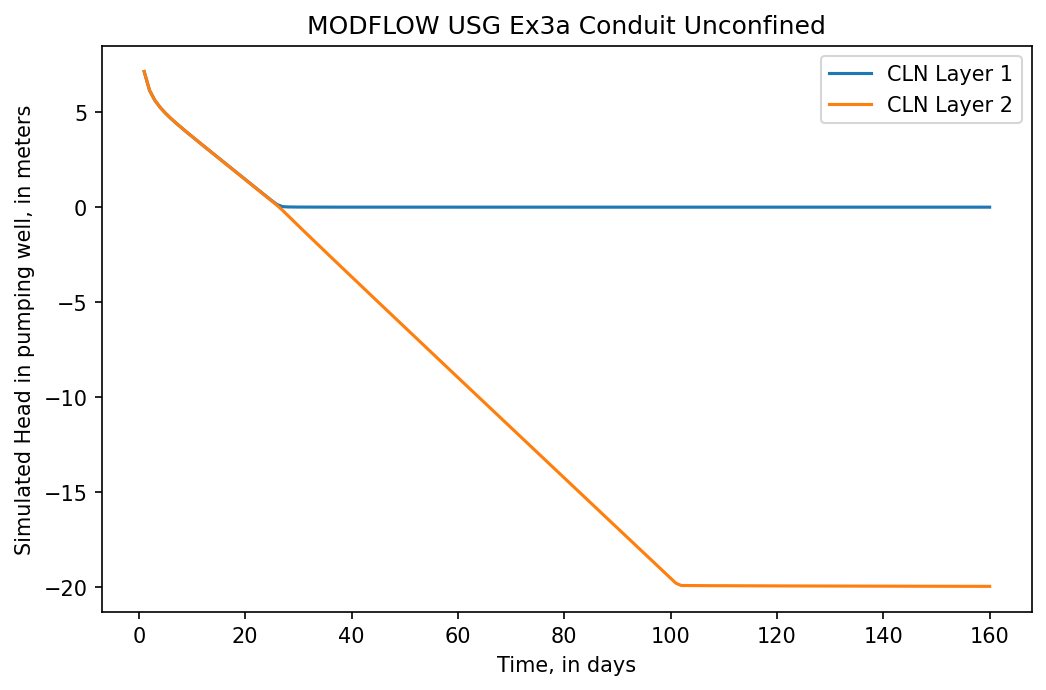

In [20]:
fig = plt.figure(figsize=(8, 5), dpi=150)
ax = fig.add_subplot(111)
ax.plot(simtimes, head_case1[0], label="CLN Layer 1")
ax.plot(simtimes, head_case1[1], label="CLN Layer 2")
ax.set_xlabel("Time, in days")
ax.set_ylabel("Simulated Head in pumping well, in meters")
ax.set_title("MODFLOW USG Ex3a Conduit Unconfined")
ax.legend()

In [21]:
cbb_file = os.path.join(mf.model_ws, modelname + ".clncb")
cbb = flopy.utils.CellBudgetFile(cbb_file)
# cbb.list_records()

simflow = cbb.get_data(kstpkper=(0, 0), text="GWF")[0]
for i in range(nper - 1):
    simflow = np.append(
        simflow, cbb.get_data(kstpkper=(i + 1, 0), text="GWF")[0]
    )

flow_case1 = simflow

## Modify CLN amd WEL package to example create 03B_conduit_unconfined of mfusg 1.5
The problem is solved using only one CLN conduit cell to represent the well connecting both aquifer layers. This is conceptually equivalent to the MNW methodology and does not colve for flow within the well. The behavior of unconfined flow between the well and layer 1 negalects the dry-cell condition whereby head in the well is below the bottom of layer 1.

In [22]:
modelname = "ex03b"
model_ws = os.path.join(cln_ws, modelname)

mf.model_ws = model_ws
mf._set_name(modelname)
for i, fname in enumerate(mf.output_fnames):
    mf.output_fnames[i] = modelname + os.path.splitext(fname)[1]


creating model workspace...
   ..\..\..\..\AppData\Local\Temp\7\tmpwqz_bf4k\ex03b

changing model workspace...
   ..\..\..\..\AppData\Local\Temp\7\tmpwqz_bf4k\ex03b


In [23]:
mf.remove_package("CLN")

node_prop = [[1, 1, 0, 30.0, -20.0, 1.57]]
cln_gwc = [
    [1, 1, 50, 50, 0, 0, 10.0, 1.0, 0],
    [1, 2, 50, 50, 0, 0, 10.0, 1.0, 0],
]

strt = 20.0
cln = flopy.mfusg.MfUsgCln(
    mf,
    ncln=1,
    iclnnds=-1,
    nndcln=1,
    nclngwc=2,
    node_prop=node_prop,
    cln_gwc=cln_gwc,
    cln_circ=cln_circ,
    strt=strt,
    unitnumber=unitnumber,
)

removing Package:  ['CLN']
adding Package:  CLN


In [24]:
mf.remove_package("WEL")

options = []
options.append("autoflowreduce")
options.append("iunitafr 55")
cln_stress_period_data = {0: [[0, -62840.0]]}

wel = flopy.mfusg.MfUsgWel(
    mf,
    ipakcb=ipakcb,
    options=options,
    cln_stress_period_data=cln_stress_period_data,
)

removing Package:  ['WEL']
Adding ex03b.afr (unit=55) to the output list.
adding Package:  WEL


In [25]:
mf.write_input()
mf.run_model(silent=True)


Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  BCF6
   Package:  SMS
   Package:  OC
   Package:  CLN
   Package:  WEL
 


(True, [])

In [26]:
head_file = os.path.join(mf.model_ws, modelname + ".clnhd")
headobj = flopy.utils.HeadFile(head_file)

simtimes = headobj.get_times()
nper = len(simtimes)
nnode = mf.cln.nclnnds

simhead = np.zeros((1, 1, nnode, nper))
for i in range(nper):
    simhead[:, :, :, i] = headobj.get_data(kstpkper=(i, 0))

head_case2 = np.squeeze(simhead)

Text(0.5, 1.0, 'MODFLOW USG Ex3b Conduit Unconfined')

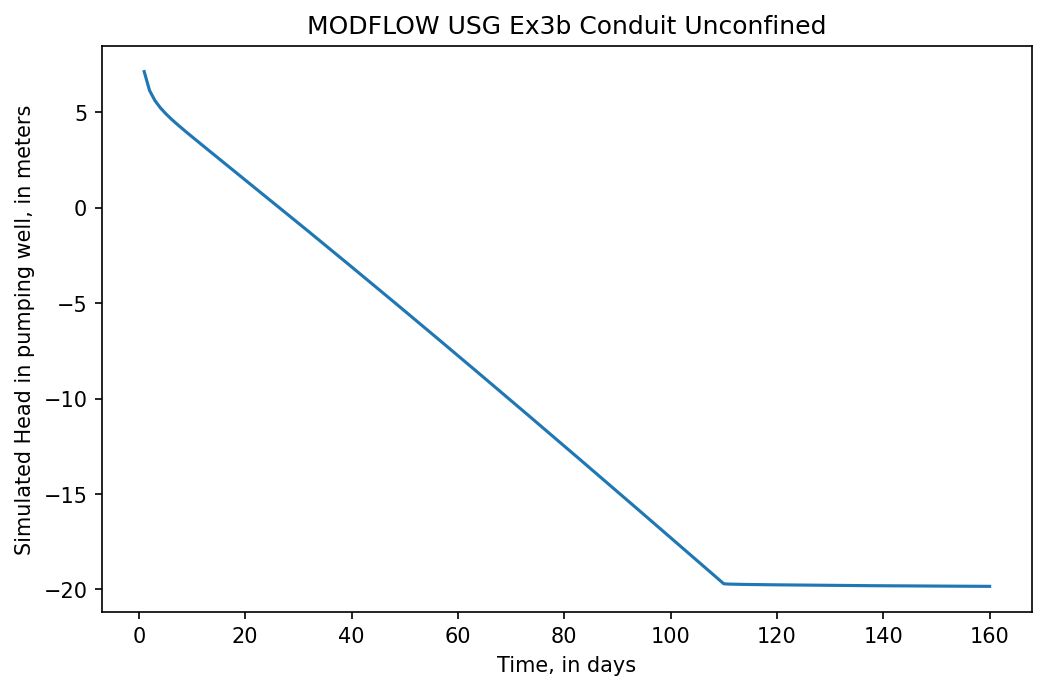

In [27]:
fig = plt.figure(figsize=(8, 5), dpi=150)
ax = fig.add_subplot(111)
ax.plot(simtimes, head_case2)
ax.set_xlabel("Time, in days")
ax.set_ylabel("Simulated Head in pumping well, in meters")
ax.set_title("MODFLOW USG Ex3b Conduit Unconfined")

In [28]:
cbb_file = os.path.join(mf.model_ws, modelname + ".clncb")
cbb = flopy.utils.CellBudgetFile(cbb_file)
# cbb.list_records()

simflow = cbb.get_data(kstpkper=(0, 0), text="GWF")[0]
for i in range(nper - 1):
    simflow = np.append(
        simflow, cbb.get_data(kstpkper=(i + 1, 0), text="GWF")[0]
    )

flow_case2 = simflow

## Modify CLN amd WEL package to example create 03C_conduit_unconfined of mfusg 1.5
The CLN well is discretized using two conduit geometry CLN cells but with the confined option for flow winthin the conduit and between CLN and GWF domains.

In [29]:
modelname = "ex03c"
model_ws = os.path.join(cln_ws, modelname)

mf.model_ws = model_ws
mf._set_name(modelname)
for i, fname in enumerate(mf.output_fnames):
    mf.output_fnames[i] = modelname + os.path.splitext(fname)[1]


creating model workspace...
   ..\..\..\..\AppData\Local\Temp\7\tmpwqz_bf4k\ex03c

changing model workspace...
   ..\..\..\..\AppData\Local\Temp\7\tmpwqz_bf4k\ex03c


In [30]:
mf.remove_package("CLN")

node_prop = [
    [1, 1, 0, 10.0, 0.0, 1.57, 1, 0],
    [2, 1, 0, 10.0, -20.0, 1.57, 1, 0],
]
cln_gwc = [
    [1, 1, 50, 50, 0, 0, 10.0, 1.0, 0],
    [2, 2, 50, 50, 0, 0, 10.0, 1.0, 0],
]

strt = [10.0, 30.0]

cln = flopy.mfusg.MfUsgCln(
    mf,
    ncln=1,
    iclnnds=-1,
    nndcln=2,
    nclngwc=2,
    node_prop=node_prop,
    cln_gwc=cln_gwc,
    cln_circ=cln_circ,
    strt=strt,
    unitnumber=unitnumber,
)

removing Package:  ['CLN']
adding Package:  CLN


In [31]:
mf.remove_package("WEL")

cln_stress_period_data = {0: [[1, -62840.0]]}

wel = flopy.mfusg.MfUsgWel(
    mf,
    ipakcb=ipakcb,
    options=options,
    cln_stress_period_data=cln_stress_period_data,
)

removing Package:  ['WEL']
adding Package:  WEL


In [32]:
mf.write_input()
mf.run_model(silent=True)


Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  BCF6
   Package:  SMS
   Package:  OC
   Package:  CLN
   Package:  WEL
 


(True, [])

In [33]:
head_file = os.path.join(mf.model_ws, modelname + ".clnhd")
headobj = flopy.utils.HeadFile(head_file)

simtimes = headobj.get_times()
nper = len(simtimes)
nnode = mf.cln.nclnnds

simhead = np.zeros((1, 1, nnode, nper))
for i in range(nper):
    simhead[:, :, :, i] = headobj.get_data(kstpkper=(i, 0))

head_case3 = np.squeeze(simhead)

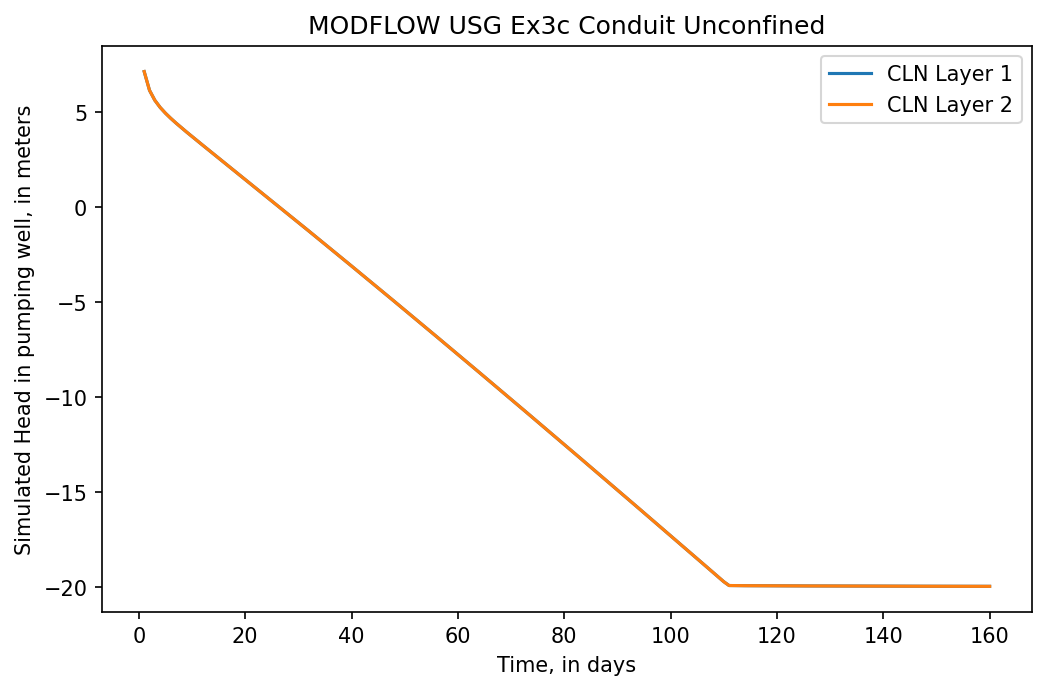

In [34]:
fig = plt.figure(figsize=(8, 5), dpi=150)
ax = fig.add_subplot(111)
ax.plot(simtimes, head_case3[0], label="CLN Layer 1")
ax.plot(simtimes, head_case3[1], label="CLN Layer 2")
ax.set_xlabel("Time, in days")
ax.set_ylabel("Simulated Head in pumping well, in meters")
ax.set_title("MODFLOW USG Ex3c Conduit Unconfined")
ax.legend()

In [35]:
cbb_file = os.path.join(mf.model_ws, modelname + ".clncb")
cbb = flopy.utils.CellBudgetFile(cbb_file)
# cbb.list_records()

simflow = cbb.get_data(kstpkper=(0, 0), text="GWF")[0]
for i in range(nper - 1):
    simflow = np.append(
        simflow, cbb.get_data(kstpkper=(i + 1, 0), text="GWF")[0]
    )

flow_case3 = simflow

## Modify CLN amd WEL package to example create 03D_conduit_unconfined of mfusg 1.5
Only one CLN cell to discretize the well but includes the "flow-to-dry-cell" option to limit flow in layer 1 when the head in the CLN cell is below the bottom of the layer.

In [36]:
modelname = "ex03d"
model_ws = os.path.join(cln_ws, modelname)

mf.model_ws = model_ws
mf._set_name(modelname)
for i, fname in enumerate(mf.output_fnames):
    mf.output_fnames[i] = modelname + os.path.splitext(fname)[1]


creating model workspace...
   ..\..\..\..\AppData\Local\Temp\7\tmpwqz_bf4k\ex03d

changing model workspace...
   ..\..\..\..\AppData\Local\Temp\7\tmpwqz_bf4k\ex03d


In [37]:
mf.remove_package("CLN")

node_prop = [[1, 1, 0, 30.0, -20.0, 1.57]]
cln_gwc = [
    [1, 1, 50, 50, 0, 0, 10.0, 1.0, 1],
    [1, 2, 50, 50, 0, 0, 10.0, 1.0, 1],
]

strt = 20.0

cln = flopy.mfusg.MfUsgCln(
    mf,
    ncln=1,
    iclnnds=-1,
    nndcln=1,
    nclngwc=2,
    node_prop=node_prop,
    cln_gwc=cln_gwc,
    cln_circ=cln_circ,
    strt=strt,
    unitnumber=unitnumber,
)

removing Package:  ['CLN']
adding Package:  CLN


In [38]:
mf.remove_package("WEL")

cln_stress_period_data = {0: [[0, -62840.0]]}

wel = flopy.mfusg.MfUsgWel(
    mf,
    ipakcb=ipakcb,
    options=options,
    cln_stress_period_data=cln_stress_period_data,
)

removing Package:  ['WEL']
adding Package:  WEL


In [39]:
mf.write_input()
mf.run_model(silent=True)


Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  BCF6
   Package:  SMS
   Package:  OC
   Package:  CLN
   Package:  WEL
 


(True, [])

In [40]:
head_file = os.path.join(mf.model_ws, modelname + ".clnhd")
headobj = flopy.utils.HeadFile(head_file)

simtimes = headobj.get_times()
nper = len(simtimes)
nnode = mf.cln.nclnnds

simhead = np.zeros((1, 1, nnode, nper))
for i in range(nper):
    simhead[:, :, :, i] = headobj.get_data(kstpkper=(i, 0))

head_case4 = np.squeeze(simhead)

In [41]:
cbb_file = os.path.join(mf.model_ws, modelname + ".clncb")
cbb = flopy.utils.CellBudgetFile(cbb_file)
# cbb.list_records()

simflow = cbb.get_data(kstpkper=(0, 0), text="GWF")[0]
for i in range(nper - 1):
    simflow = np.append(
        simflow, cbb.get_data(kstpkper=(i + 1, 0), text="GWF")[0]
    )

flow_case4 = simflow

## Comparing four cases

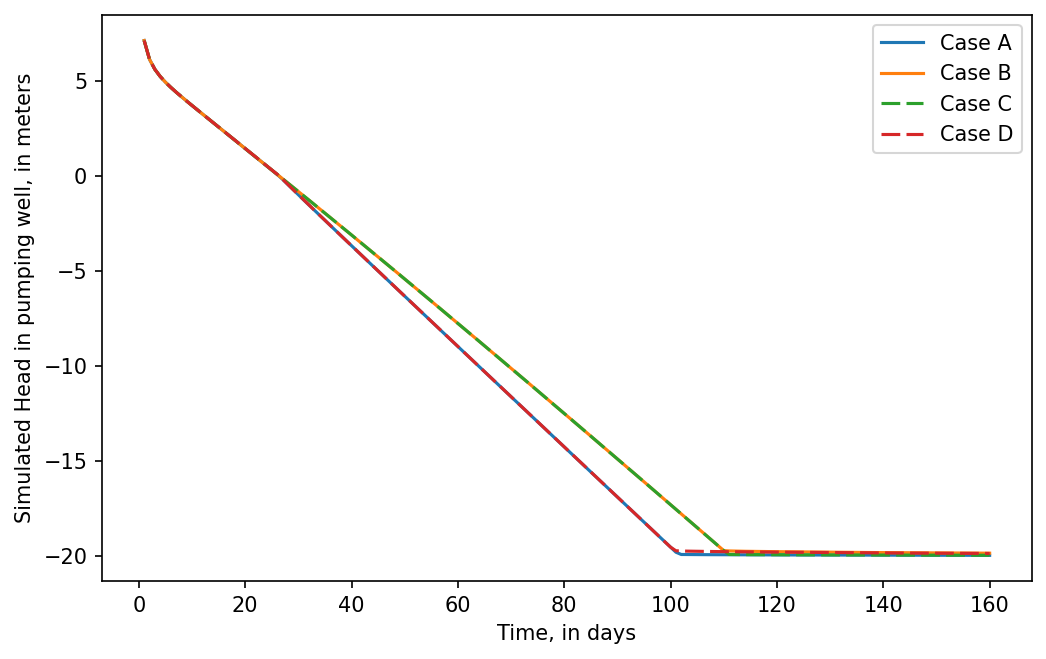

In [42]:
fig = plt.figure(figsize=(8, 5), dpi=150)
ax = fig.add_subplot(111)
ax.plot(simtimes, head_case1[1], label="Case A")
ax.plot(simtimes, head_case2, label="Case B")
ax.plot(simtimes, head_case3[1], dashes=[6, 2], label="Case C")
ax.plot(simtimes, head_case4, dashes=[6, 2], label="Case D")

ax.set_xlabel("Time, in days")
ax.set_ylabel("Simulated Head in pumping well, in meters")
ax.legend()

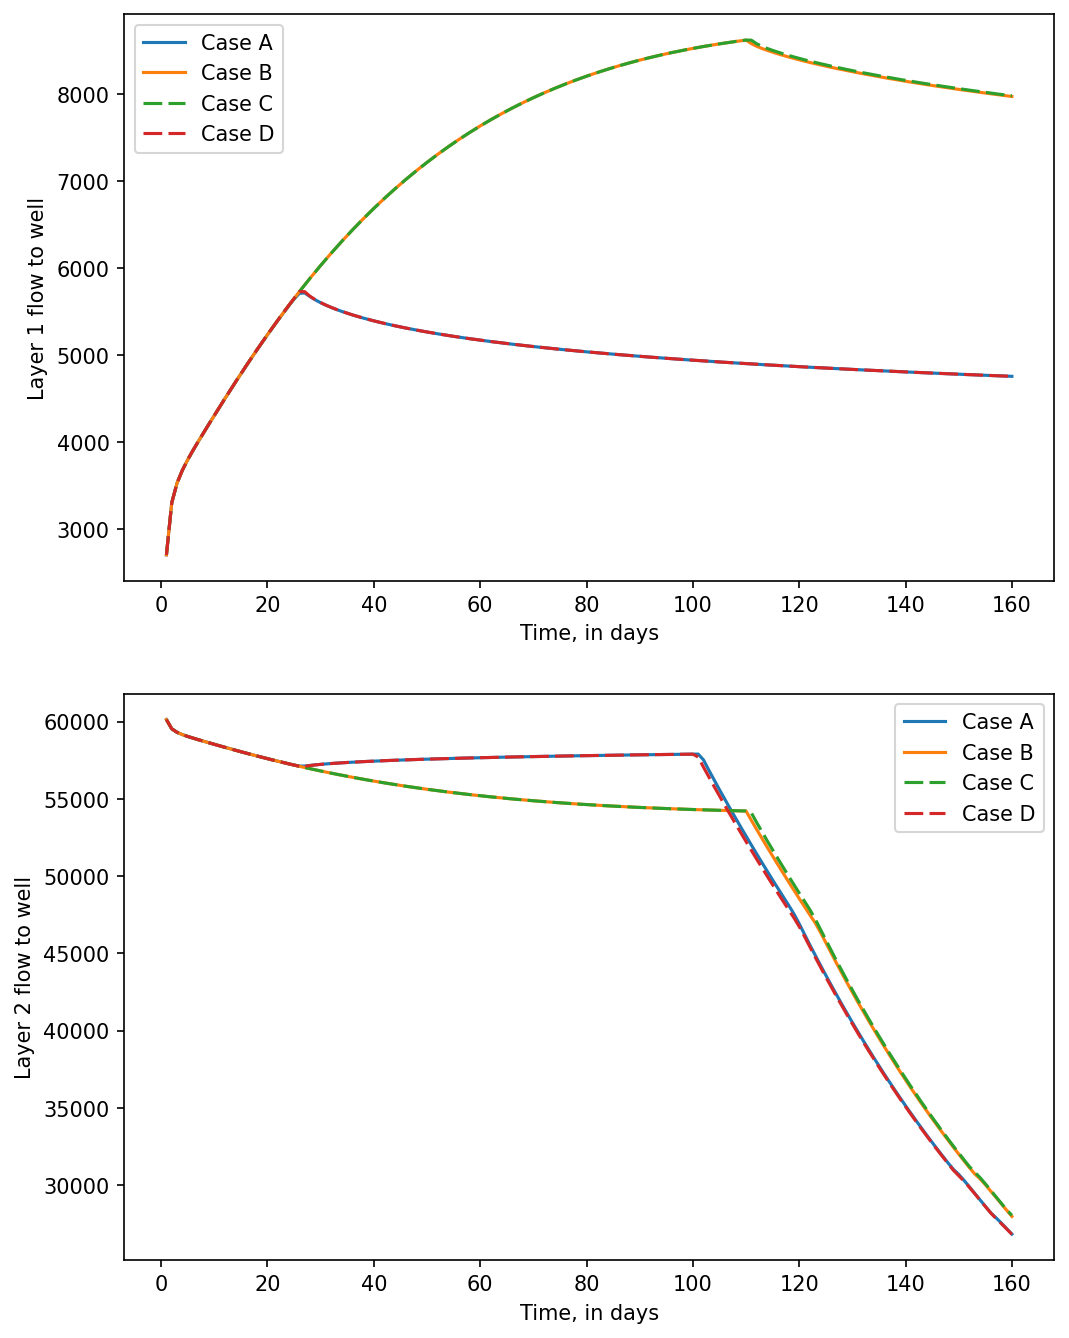

In [43]:
fig = plt.figure(figsize=(8, 11), dpi=150)
ax1 = fig.add_subplot(211)
ax1.plot(
    simtimes,
    flow_case1[
        ::2,
    ]["q"],
    label="Case A",
)
ax1.plot(
    simtimes,
    flow_case2[
        ::2,
    ]["q"],
    label="Case B",
)
ax1.plot(
    simtimes,
    flow_case3[
        ::2,
    ]["q"],
    dashes=[6, 2],
    label="Case C",
)
ax1.plot(
    simtimes,
    flow_case4[
        ::2,
    ]["q"],
    dashes=[6, 2],
    label="Case D",
)
ax1.set_xlabel("Time, in days")
ax1.set_ylabel("Layer 1 flow to well")
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(
    simtimes,
    flow_case1[
        1::2,
    ]["q"],
    label="Case A",
)
ax2.plot(
    simtimes,
    flow_case2[
        1::2,
    ]["q"],
    label="Case B",
)
ax2.plot(
    simtimes,
    flow_case3[
        1::2,
    ]["q"],
    dashes=[6, 2],
    label="Case C",
)
ax2.plot(
    simtimes,
    flow_case4[
        1::2,
    ]["q"],
    dashes=[6, 2],
    label="Case D",
)
ax2.set_xlabel("Time, in days")
ax2.set_ylabel("Layer 2 flow to well")
ax2.legend()